In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score


In [18]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")

X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")

train_ids = np.load("train_ids.npy")
val_ids = np.load("val_ids.npy")

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


(2432, 15) (2432,)
(608, 15) (608,)


In [19]:
class PropertyDataset(Dataset):
    def __init__(self, X, y, ids, split):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.ids = ids
        self.split = split

        self.tf = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = Image.open(
            f"images/{self.split}/{self.ids[idx]}.0.png"
        ).convert("RGB")

        img = self.tf(img)

        return img, self.X[idx], self.y[idx]


In [20]:
train_ds = PropertyDataset(X_train, y_train, train_ids, "train")
val_ds   = PropertyDataset(X_val, y_val, val_ids, "train")

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)


In [21]:
class MultiModalModel(nn.Module):
    def __init__(self, tab_dim):
        super().__init__()

        self.cnn = models.resnet18(pretrained=True)

        for name, param in self.cnn.named_parameters():
            if "layer4" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.cnn.fc = nn.Identity()

        self.tabular = nn.Sequential(
            nn.Linear(tab_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc = nn.Linear(512 + 128, 1)

    def forward(self, img, tab):
        img_feat = self.cnn(img)
        tab_feat = self.tabular(tab)
        return self.fc(torch.cat([img_feat, tab_feat], dim=1)).squeeze()


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MultiModalModel(X_train.shape[1]).to(device)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4
)
loss_fn = nn.MSELoss()


c:\Users\surendhar reddy\OneDrive\projects\satellite_property_valuation\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\surendhar reddy\OneDrive\projects\satellite_property_valuation\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
for epoch in range(20):
    model.train()
    for img, tab, y in train_loader:
        img, tab, y = img.to(device), tab.to(device), y.to(device)

        optimizer.zero_grad()
        loss = loss_fn(model(img, tab), y)
        loss.backward()
        optimizer.step()

    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for img, tab, y in val_loader:
            p = model(img.to(device), tab.to(device)).cpu().numpy()
            preds.extend(p)
            gts.extend(y.numpy())

    rmse = mean_squared_error(gts, preds) ** 0.5
    r2 = r2_score(gts, preds)

    print(f"Epoch {epoch}: RMSE={rmse:.2f}, R2={r2:.3f}")


Epoch 0: RMSE=0.30, R2=0.688
Epoch 1: RMSE=0.29, R2=0.696
Epoch 2: RMSE=0.30, R2=0.678
Epoch 3: RMSE=0.29, R2=0.705
Epoch 4: RMSE=0.29, R2=0.708
Epoch 5: RMSE=0.28, R2=0.731
Epoch 6: RMSE=0.28, R2=0.717
Epoch 7: RMSE=0.27, R2=0.735
Epoch 8: RMSE=0.27, R2=0.740
Epoch 9: RMSE=0.27, R2=0.740
Epoch 10: RMSE=0.27, R2=0.746
Epoch 11: RMSE=0.26, R2=0.760
Epoch 12: RMSE=0.26, R2=0.756
Epoch 13: RMSE=0.26, R2=0.764
Epoch 14: RMSE=0.29, R2=0.701
Epoch 15: RMSE=0.25, R2=0.774
Epoch 16: RMSE=0.25, R2=0.773
Epoch 17: RMSE=0.25, R2=0.776
Epoch 18: RMSE=0.25, R2=0.775
Epoch 19: RMSE=0.25, R2=0.774


In [ ]:
torch.save(model.state_dict(), "multimodal_model.pth")


In [ ]:
torch.save(model.state_dict(), "multimodal_model.pth")


In [ ]:
X_test = np.load("X_test.npy")
test_ids = np.load("test_ids.npy")


In [ ]:
class TestDataset(Dataset):
    def __init__(self, X, ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.ids = ids
        self.tf = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = Image.open(
            f"images/test/{self.ids[idx]}.0.png"
        ).convert("RGB")
        return self.tf(img), self.X[idx]


In [ ]:
test_ds = TestDataset(X_test, test_ids)
test_loader = DataLoader(test_ds, batch_size=16)

model.eval()
log_preds = []

with torch.no_grad():
    for img, tab in test_loader:
        p = model(img.to(device), tab.to(device)).cpu().numpy()
        log_preds.extend(p)

price_preds = np.expm1(np.array(log_preds))


In [ ]:
import pandas as pd

pd.DataFrame({
    "id": test_ids,
    "predicted_price": price_preds
}).to_csv("submission.csv", index=False)


## Grad Cam


In [ ]:
import torch
import cv2
import numpy as np


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, img_tensor, tab_tensor):
        self.model.zero_grad()
        output = self.model(img_tensor, tab_tensor)
        output.backward()

        grads = self.gradients
        acts = self.activations

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam


In [ ]:
from PIL import Image
from torchvision import transforms


In [ ]:
idx = 0

img_path = f"images/train/{val_ids[idx]}.0.png"
img = Image.open(img_path).convert("RGB")

tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img_tensor = tf(img).unsqueeze(0).to(device)
tab_tensor = torch.tensor(X_val[idx], dtype=torch.float32).unsqueeze(0).to(device)


In [ ]:
gradcam = GradCAM(model, model.cnn.layer4)
cam = gradcam.generate(img_tensor, tab_tensor)


c:\Users\surendhar reddy\OneDrive\projects\satellite_property_valuation\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [ ]:
import matplotlib.pyplot as plt


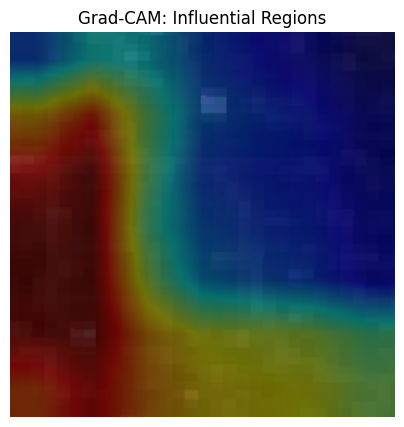

In [ ]:
img_np = np.array(img.resize((224,224)))

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM: Influential Regions")
plt.show()


In [ ]:
NUM_SAMPLES = 5


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms


In [ ]:
os.makedirs("gradcam_outputs", exist_ok=True)

tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

gradcam = GradCAM(model, model.cnn.layer4)

model.eval()

for i in range(NUM_SAMPLES):
    img_path = f"images/train/{val_ids[i]}.0.png"
    img = Image.open(img_path).convert("RGB")

    img_tensor = tf(img).unsqueeze(0).to(device)
    tab_tensor = torch.tensor(
        X_val[i], dtype=torch.float32
    ).unsqueeze(0).to(device)

    cam = gradcam.generate(img_tensor, tab_tensor)

    img_np = np.array(img.resize((224,224)))
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam), cv2.COLORMAP_JET
    )

    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    save_path = f"gradcam_outputs/gradcam_{i}.png"
    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    print(f"Saved {save_path}")


Saved gradcam_outputs/gradcam_0.png
Saved gradcam_outputs/gradcam_1.png
Saved gradcam_outputs/gradcam_2.png
Saved gradcam_outputs/gradcam_3.png
Saved gradcam_outputs/gradcam_4.png


c:\Users\surendhar reddy\OneDrive\projects\satellite_property_valuation\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [ ]:
import pandas as pd

df = pd.read_csv("submission.csv")
print(df.head())
print(df.columns)


           id  predicted_price
0  2591820310        390859.97
1  7974200820        756539.56
2  7701450110        881667.50
3  9522300010       2419811.50
4  9510861140        553052.70
Index(['id', 'predicted_price'], dtype='object')


In [ ]:
print(len(df), len(test_ids))


3004 3004


In [ ]:
df["predicted_price"].head()


0     390859.97
1     756539.56
2     881667.50
3    2419811.50
4     553052.70
Name: predicted_price, dtype: float64

In [ ]:
df["predicted_price"].nunique()


2992

In [ ]:
df["id"].equals(pd.Series(test_ids))


True

## Tabular only


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")

X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")


In [ ]:
train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)

val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


In [ ]:
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TabularModel(X_train.shape[1]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [ ]:
for epoch in range(20):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        optimizer.step()

    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for x, y in val_loader:
            p = model(x.to(device)).cpu().numpy()
            preds.extend(p)
            gts.extend(y.numpy())

    rmse = (mean_squared_error(gts, preds)) ** 0.5
    r2 = r2_score(gts, preds)

    print(f"Epoch {epoch}: RMSE={rmse:.3f}, R2={r2:.3f}")


Epoch 0: RMSE=0.337, R2=0.599
Epoch 1: RMSE=0.324, R2=0.629
Epoch 2: RMSE=0.339, R2=0.595
Epoch 3: RMSE=0.333, R2=0.608
Epoch 4: RMSE=0.318, R2=0.644
Epoch 5: RMSE=0.328, R2=0.622
Epoch 6: RMSE=0.316, R2=0.648
Epoch 7: RMSE=0.318, R2=0.645
Epoch 8: RMSE=0.308, R2=0.665
Epoch 9: RMSE=0.307, R2=0.669
Epoch 10: RMSE=0.305, R2=0.671
Epoch 11: RMSE=0.321, R2=0.636
Epoch 12: RMSE=0.301, R2=0.681
Epoch 13: RMSE=0.316, R2=0.648
Epoch 14: RMSE=0.322, R2=0.635
Epoch 15: RMSE=0.304, R2=0.674
Epoch 16: RMSE=0.316, R2=0.649
Epoch 17: RMSE=0.310, R2=0.661
Epoch 18: RMSE=0.340, R2=0.593
Epoch 19: RMSE=0.305, R2=0.673


## comaprision of tabular only vs tabular+satellite images


from above we got values of rmse and r2 for both tabular and tabular+satellite images they are as follows
Model Performance Comparison
```
| Model | RMSE ↓ | R² ↑ |
|------|--------|------|
| Tabular Only | 0.305 | 0.673 |
| Tabular + Satellite Images | **0.250** | **0.774** |
```

The multimodal model that incorporates satellite imagery outperforms the
tabular-only baseline, achieving a lower RMSE and higher R² score. This
improvement indicates that satellite images provide complementary environmental
information that is not fully captured by structured housing attributes alone.
The inclusion of satellite imagery leads to a modest but consistent improvement
in predictive performance over the tabular-only model. This suggests that visual
environmental cues extracted by the CNN contribute additional signal beyond
traditional tabular features.


## price vs predicted price for multimodel

In [14]:
import numpy as np
import torch

model.eval()
preds = []
gts = []

with torch.no_grad():
    for img, tab, y in val_loader:
        img = img.to(device)
        tab = tab.to(device)

        output = model(img, tab).cpu().numpy()
        preds.extend(output.flatten())
        gts.extend(y.numpy().flatten())

preds = np.array(preds)
gts = np.array(gts)


In [15]:
preds = np.expm1(preds)
gts = np.expm1(gts)


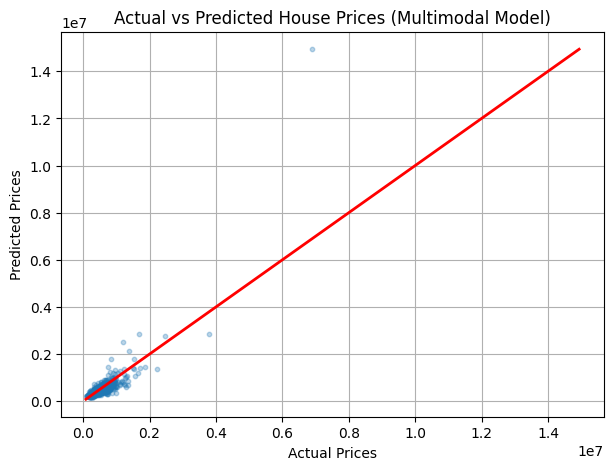

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(gts, preds, alpha=0.3, s=10)

# Perfect prediction line
min_val = min(gts.min(), preds.min())
max_val = max(gts.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linewidth=2)

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices (Multimodal Model)")
plt.grid(True)
plt.show()


Figure X shows the relationship between actual and predicted prices for the
multimodal model. Predictions closely follow the ideal diagonal trend for the
majority of properties, while dispersion increases at higher price ranges due
to the scarcity of high-value examples and the inherent difficulty of predicting
extreme prices.
